In [ ]:
# Importing Libraries 
import numpy as np
import pandas as pd 
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# =========================
# Loading data into dataframe
# =========================
from dotenv import load_dotenv
import os
load_dotenv()
data_path = os.getenv("PATH")
df = pd.read_csv(data_path, index_col="PassengerId") 

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.05,NaN,S


In [ ]:
# Count of missing values
df.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex          86
Age         177
SibSp         0
Parch         0
Ticket        1
Fare        327
Cabin       687
Embarked    420
dtype: int64

In [ ]:
# Handling Missing values

# Age → mean
df["Age"] = df["Age"].fillna(df["Age"].mean())

# Fare → convert to numeric + median
df["Fare"] = pd.to_numeric(df["Fare"], errors="coerce")
df["Fare"] = df["Fare"].fillna(df["Fare"].median())

# Sex → mode
df["Sex"] = df["Sex"].fillna(df["Sex"].mode()[0])

# Embarked → mode
df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode()[0])

# Cabin → Deck extraction
df["Deck"] = df["Cabin"].str[0]
df["Deck"] = df["Deck"].fillna("Missing")
df.drop(columns=["Cabin"], inplace=True)

# Ticket → drop rows with missing ticket
df.dropna(subset=["Ticket"], inplace=True)



In [ ]:

# Performing Label Encoding on copy of df
df_copy = df.copy()

le = LabelEncoder() # Creating object of LabelEncoder

df_copy["Sex_encoded"] = le.fit_transform(df_copy["Sex"])  # using label encoder male -> 1 , female -> 0
df_copy.drop(columns=["Sex"],inplace=True)  # drop the original col of Sex with Sex_encoded


# Performing ONE - Hot encoding on copy of df

df_copy = pd.get_dummies(df_copy,columns=["Embarked"],drop_first=True) # Creates three cols Embarked_C Embarked_S Embarked_Q  we will drop first col

bool_cols = df_copy.select_dtypes(include="bool").columns  # selecting all boolean columns from df_copy
df_copy[bool_cols] = df_copy[bool_cols].astype(int)  # converting the data type to int using astype()

df_copy.head(10)


,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Deck,Sex_encoded,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",22.000000,1,0,A/5 21171,7.2500,Missing,79,0,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.000000,1,0,PC 17599,71.2833,C,78,0,0
3,1,3,"Heikkinen, Miss. Laina",26.000000,0,0,STON/O2. 3101282,7.9250,Missing,78,0,1
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.000000,1,0,113803,53.1000,C,78,0,1
5,0,3,"Allen, Mr. William Henry",35.000000,0,0,373450,8.0500,Missing,79,0,1
6,0,3,"Moran, Mr. James",18.897677,0,0,330877,8.4583,Missing,79,1,0
7,0,1,"McCarthy, Mr. Timothy J",54.000000,0,0,17463,51.8625,E,79,0,1
8,0,3,"Palsson, Master. Gosta Leonard",2.000000,3,1,349909,21.0750,Missing,79,0,1
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",27.000000,0,2,347742,11.1333,Missing,78,0,1


In [ ]:
# Drop string columns
df_copy.drop(columns=["Name", "Ticket"], inplace=True)

# Converting to numeric types from object 
df_copy["Pclass"] = pd.to_numeric(df_copy["Pclass"], errors="coerce")
df_copy["Parch"] = pd.to_numeric(df_copy["Parch"], errors="coerce")

# Features & target
X = df_copy[
    ["Pclass", "Age", "SibSp", "Parch", "Fare", "Sex_encoded", "Embarked_Q", "Embarked_S"]
]

y = df_copy["Survived"]
X = X.dropna()      # Remove rows from X that contains NaN
y = y.loc[X.index]  # Keeps only those rows in y  Whose index exists in X  Restores perfect alignment


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
X_train.head()
X_train.dtypes

Pclass         float64
Age            float64
SibSp            int64
Parch          float64
Fare           float64
Sex_encoded      int64
Embarked_Q       int64
Embarked_S       int64
dtype: object

In [ ]:

# Scaling
standard_scaler = StandardScaler()

X_train.loc[:, ["Age","Fare"]] = standard_scaler.fit_transform(
    X_train[["Age","Fare"]]
)
X_test.loc[:, ["Age","Fare"]] = standard_scaler.transform(
    X_test[["Age","Fare"]]
)

X_train.head()


,Pclass,Age,SibSp,Parch,Fare,Sex_encoded,Embarked_Q,Embarked_S
PassengerId,,,,,,,,
332,1.0,1.324795,0,0.0,-0.078684,79,0,1
734,2.0,-0.323356,0,0.0,-0.377145,79,0,1
383,3.0,0.335904,0,0.0,-0.474867,79,0,1
705,3.0,-0.103603,1,0.0,-0.476230,79,0,1
814,3.0,-1.568626,4,2.0,-0.025249,78,0,1


ValueError: could not convert string to float: 'Angheloff, Mr. Minko'
 Due to this c error converting Pclass & Parch to numeric

In [ ]:

# Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Predictions
model_predictions = model.predict(X_test)


In [ ]:

# Metrics
acc = accuracy_score(y_test, model_predictions)
f1 = f1_score(y_test, model_predictions)
precision = precision_score(y_test, model_predictions)
recall = recall_score(y_test, model_predictions)

print("Accuracy :", acc)
print("F1 Score :", f1)
print("Precision:", precision)
print("Recall   :", recall)

Accuracy : 0.7988826815642458
F1 Score : 0.7464788732394366
Precision: 0.7794117647058824
Recall   : 0.7162162162162162


In [ ]:
# Comparison dataframe
comparison_df = pd.DataFrame({
    "Actual": y_test.values,
    "Predicted": model_predictions
})

comparison_df.head(10)

,Actual,Predicted
0,1,0
1,0,0
2,0,0
3,1,1
4,1,1
5,1,1
6,1,1
7,0,0
8,1,1
9,1,1


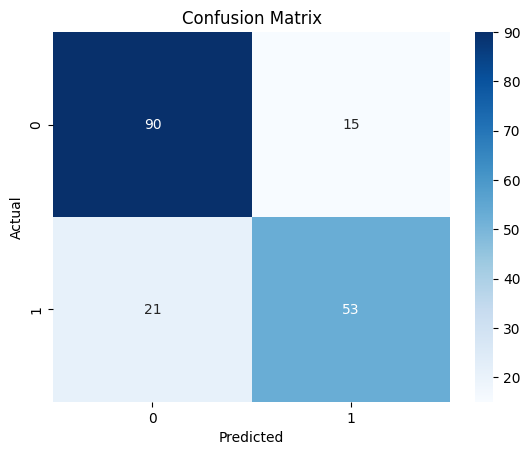

In [ ]:
# Creating a confusion matrix
cm = confusion_matrix(y_test, model_predictions)

sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()